# Advantage Actor-Critic

Much of this code was adapted from this excellent article on Medium put out by Tensorflow:
https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296

Although they build an Asynchronous Advantage Actor Critic (A3C) model (while we're only building an A2C model), the code they wrote is so clean and intuitive that I was able to adapt it to the much simpler A2C model.  Even more, the article's utilization of Tensorflow's Eager Execution and Model Subclassing makes it possible to really explore how these models work and construct them from the ground up.  It's a pretty good read.

First, we import some useful libraries.

In [1]:
%load_ext autoreload
%autoreload 2
import gym
import time
import threading
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

Next, we import `tensorflow` as `tf`.  We also import Tensorflow's Keras submodule so that we can build these models with ease using Tensorflow's Model Subclassing.

https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

We enable eager execution so that we can more readily experiment with the models we need.  TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later.

https://www.tensorflow.org/guide/eager

In [2]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

In order to build an A2C model, we need to first build the critic model and the actor model.  The critic model is used to approximate the value of any state in an environment, while the actor is used to produce a probability of the actions we can take as the agent.  We can use the critic to determine which actions performed are favorible by calculating their advantage, which will then allow us to train our actor to make those favourable actions more likley.

## Critic Model

First, we define the critic.  This model will recieve the observation as input and will return the value of the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size 1.

In [3]:
class CriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(CriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values

We can quickly test to see if our critic can learn a basic XOR dataset.  First, we create the XOR data and initialize our critic.

In [4]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

Next, we perform backpropagation to train the critic.  First, we pass the XOR input data through the critic to perform forward propagation, then we calculate the negative MSE of the actual XOR output data and the critic's output.  We perform both of these operations within the `GradientTape` context manager, which records operations for automatic differentiation.  
We can then call the resulting `tape.gradient` method with the loss and weights we want to recieve the gradients for (i.e., the critic's trainable_weights).  This gives us back the gradients as tensors.  We can then iterate through the gradients and the critic's corresponding weights and add the gradients (multiplied by our learning rate `lr`) to the weights.

This will complete one iteration of backpropagation for our critic.  We repeat this process for `epochs` iterations, which should result in fairly accurate results.

https://www.tensorflow.org/api_docs/python/tf/GradientTape

- critic_loss:
 tf.Tensor(-0.048564937, shape=(), dtype=float32)

- output_data:
 [[0]
 [1]
 [1]
 [0]]

- values:
 tf.Tensor(
[[0.14762366]
 [0.91861075]
 [0.88831854]
 [0.08760841]], shape=(4, 1), dtype=float32)



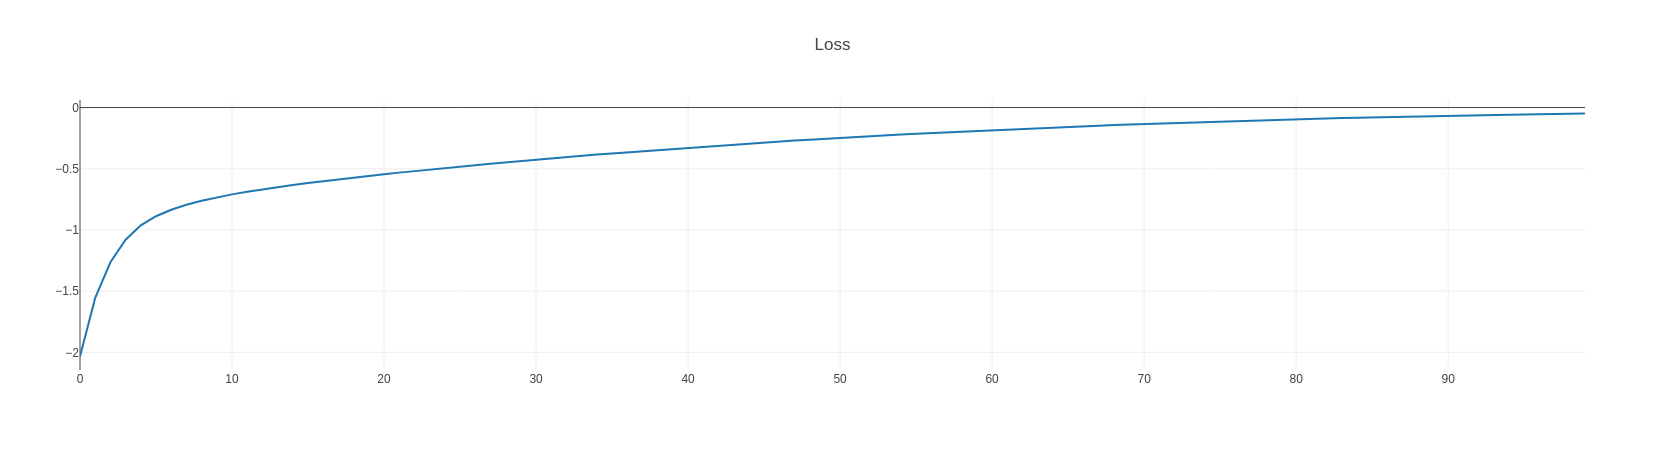

In [5]:
lr = 0.01
epochs = 100
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    losses.append(float(critic_loss))
    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)

print('- critic_loss:\n', critic_loss)
print('\n- output_data:\n', output_data)
print('\n- values:\n', values)
print()

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(losses)), y=losses)],
    "layout": go.Layout(title="Loss")
})

In the above example, the critic is learning a finite, arbitrary mapping.  In our application, we want the critic to be able to accurately predict the expected future discounted rewards for a given state (i.e., our value).  In essense, it's the same task as above, but instead of learning a mapping from input data to output data, we instead generate the input data by stepping through an environment (i.e., _observations_) and calculate the true discounted future rewards per episode, then learn the mapping between the two.

To demonstrate this process, we will construct a simple example.  Consider an environment with `no_states` different states, and a policy $\pi$ which will simulate an ideal agent's policy.  So, for every state the "agent" passes through, the agent will net a reward of `1`.  If an episode consists of 3 states, then we expect the total net reward to be `3` (+ `1` for each state).  This means that, with a discounting factor $\gamma = 0.99$, we can compute discounted future rewards with the following function:

In [6]:
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

get_discounted_rewards([1, 1, 1])

[2.9701, 1.99, 1.0]

So, in the first state, we expect our critic to learn that our future discounted rewards to be `2.9701`, then `1.99` for the second state, then `1.0` for the last state.  We can see in the following example that our critic can learn this fairly quickly.

- critic_loss:
 tf.Tensor(-0.00070147816, shape=(), dtype=float32)

- observations:
 tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

- discounted_rewards:
 [[2.9701]
 [1.99  ]
 [1.    ]]

- values:
 tf.Tensor(
[[2.963895 ]
 [1.9804572]
 [1.0239147]], shape=(3, 1), dtype=float32)



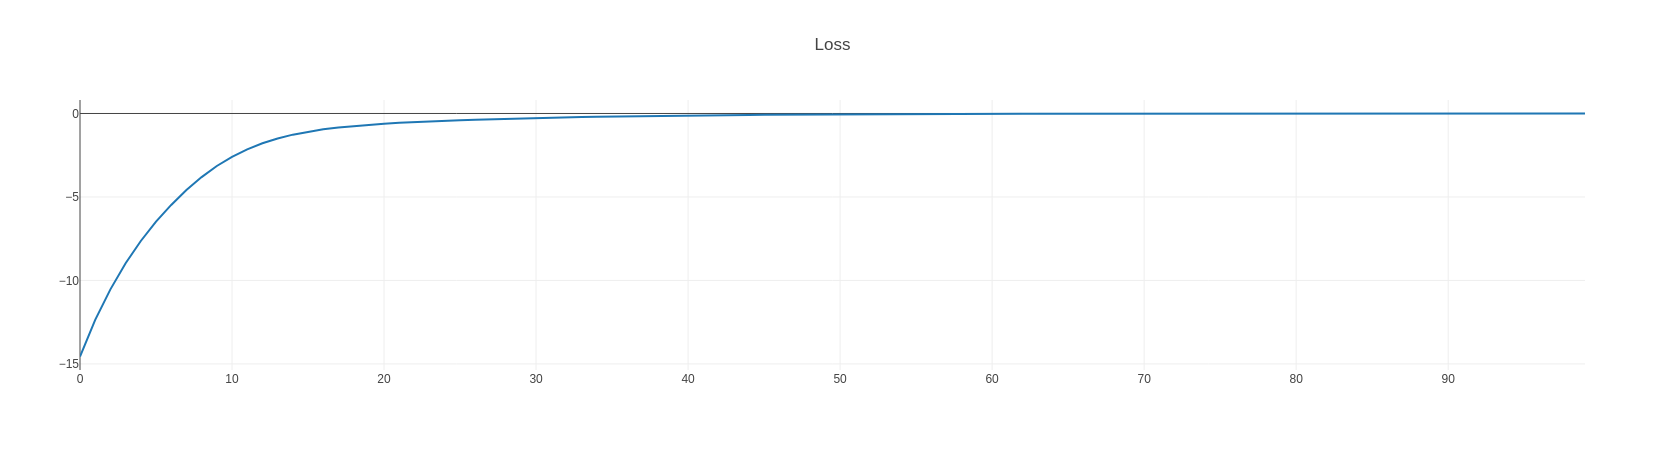

In [7]:
no_states = 3
critic = CriticModel(len(input_data[0]), len(output_data[0]))
observations = tf.one_hot(np.arange(no_states), no_states)
discounted_rewards = np.array(get_discounted_rewards([1, 1, 1])).reshape(no_states, 1)
losses = []

lr = 0.005
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = critic(observations)
        critic_loss = -tf.reduce_sum((discounted_rewards - values)**2)

    losses.append(float(critic_loss))
    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)
        
print('- critic_loss:\n', critic_loss)
print('\n- observations:\n', observations)
print('\n- discounted_rewards:\n', discounted_rewards)
print('\n- values:\n', values)
print()
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(losses)), y=losses)],
    "layout": go.Layout(title="Loss")
})

Of course, the critic has a pretty easy job: our "policy" in the above example is perfect in that it always makes the correct move.  Not only that, but the "environment" is very simple.  The set of observations is small, and the resulting rewards are consistent.  In reality, our critic needs to be more robust and be able to learn a descent approximation for our value function in stochastic environments with less-than-ideal agents.

To demonstrate that our critic can learn a descent value function for more complex environments, consider an example where the reward for any given state is randomly sampled from a normal distribution (with mean `0.5` and standard deviation `0.5`).  This will simulate a policy that is more volatile.

The following function will generate an episodes worth of rewards:

In [8]:
np.random.normal(0.5, 0.5, 3)

array([ 0.44662391, -0.34713797,  1.36068654])

We'll be, of course, learning discounted rewards:

In [9]:
get_discounted_rewards(np.random.normal(0.5, 0.5, 3))

[1.9750487422531773, 0.8158115079031942, -0.16735606360158028]

To see what our critic _should_ learn, we can generate a number of discounted rewards and find what the mean should be around:

In [10]:
total_discounted_rewards = []
for epoch in range(1000):
    discounted_rewards = np.array(get_discounted_rewards(np.random.normal(0.5, 0.5, 3))).reshape(no_states, 1)
    total_discounted_rewards.append(discounted_rewards)
    
np.mean(total_discounted_rewards, axis=0)

array([[1.44048772],
       [0.96838375],
       [0.47462592]])

The average discounted values should be around `[1.5, 1.0, 0.5]`.  Now, let's train a critic in this more complex "environment":

In [11]:
no_states = 3
critic = CriticModel(len(input_data[0]), len(output_data[0]))
observations = tf.one_hot(np.arange(no_states), no_states)
total_discounted_rewards = []
losses = []

lr = 0.005
epochs = 100
for epoch in range(epochs):
    discounted_rewards = np.array(get_discounted_rewards(np.random.normal(0.5, 0.5, 3))).reshape(no_states, 1)
    total_discounted_rewards.append(discounted_rewards)
    with tf.GradientTape() as tape:
        values = critic(observations)
        critic_loss = -tf.reduce_mean((discounted_rewards - values)**2)

    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)
        
print('- critic_loss:\n', critic_loss)
print('\n- mean of total_discounted_rewards:\n', np.mean(total_discounted_rewards, axis=0))
print('\n- values:\n', values)
print()

- critic_loss:
 tf.Tensor(-0.09293007, shape=(), dtype=float32)

- mean of total_discounted_rewards:
 [[1.52239573]
 [0.97753291]
 [0.46941087]]

- values:
 tf.Tensor(
[[1.1413863]
 [0.8122486]
 [0.5962968]], shape=(3, 1), dtype=float32)



We can visualize and experiment with this process by watching how our critic can learn a variety of different configurations.

In [12]:
# This cell is used only to setup the follow interaction
# Feel free to ignore how it works.

# Plotting
def get_critic_plot_layout(no_states):
    layout = dict(
        title="Predicted Values per State",
        annotations=[],
        #showlegend=False
    )
    states = np.arange(no_states)
    for state in states:
        axis = state + 1
        layout[f'xaxis{axis}'] = dict(
            domain=[(1./no_states)*state, (1./no_states)*(state+1)]
        )
        layout[f'yaxis{axis}'] = dict(
            anchor=f"x{axis}",
            showticklabels=False,
            linecolor='black',
            range=[-10,10]
        )
        layout["annotations"].append(dict(
            text=f"State {state}",
            font=dict(
              size=13,
              color='rgb(116, 101, 130)',
            ),
            showarrow=False,
            align='center',
            x=np.linspace(0.1,0.9,no_states)[state],
            y=-0.15,
            xref='paper',
            yref='paper',
          ))
        if state == 0:
            layout[f'yaxis{axis}']["showticklabels"] = True

    return go.Layout(**layout)

    
def get_critic_plot_data(no_states, window=100):
    data = []
    states = np.arange(no_states)
    for state in states:
        axis = state + 1

        data.append(
            go.Scatter(
                x=np.arange(window),
                y=np.zeros(window),
                xaxis=f'x{axis}',
                yaxis=f'y{axis}',
                name=f"State Losses {state}"
            )
        )

        data.append(
            go.Scatter(
                x=np.arange(window),
                y=np.zeros(window),
                xaxis=f'x{axis}',
                yaxis=f'y{axis}',
                name=f"State Discounted Rewards {state}"
            )
        )

    return data

# Running
def run_critic_test(no_states=3, mean=0.5, std=0.5):
    lr = 0.005
    discounted_rewards = np.array(get_discounted_rewards(
        np.random.normal(mean, std, no_states)
    )).reshape(no_states, 1)

    with tf.GradientTape() as tape:
        values = critic(observations)
        predictions = values.numpy()
        squared_error = (discounted_rewards - values)**2
        critic_loss = -tf.reduce_mean(squared_error)

    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)

    return predictions, discounted_rewards

def update_chart(fig, index, values):
    updated_values = np.roll(fig.data[index]["y"], -len(values))
    updated_values[-len(values):] = values
    fig.data[index]["y"] = updated_values

def run_plot_update(no_states=3, mean=0.5, std=0.5, batch_size=1):
    plot_data = {}
    for j in range(batch_size):
        _preds, _drs = run_critic_test(no_states, mean, std)
        index = 0
        for i, (pred, dr) in enumerate(zip(_preds, _drs)):
            if index in plot_data:
                plot_data[index][j] = pred[0]
            else:
                plot_data[index] = np.zeros(batch_size)
                plot_data[index][j] = pred[0]
            index += 1

            if index in plot_data:
                plot_data[index][j] = dr[0]
            else:
                plot_data[index] = np.zeros(batch_size)
                plot_data[index][j] = dr[0]
            index += 1

    for key in plot_data:
        update_chart(fig, key, plot_data[key])
        
# Widgets

out = widgets.Output(layout={'border': '1px solid black'})

no_states = 3
mean = 0.5
std = 0.5
critic = CriticModel(no_states, 1)

layout = get_critic_plot_layout(no_states)
data = get_critic_plot_data(no_states)
fig = go.FigureWidget(data=data, layout=layout)

mean_slider = widgets.FloatSlider(
    value=mean,
    min=-2.0,
    max=2.0,
    step=0.25,
    description='mean',
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(
        width='50%'
    )
)

std_slider = widgets.FloatSlider(
    value=std,
    min=0,
    max=2.0,
    step=0.25,
    description='std',
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(
        width='50%'
    )
)

def get_slider_callback(value):
    if value == 'mean':
        def slider_callback(change):
            global mean
            with out:
                if change['name'] == 'value':
                    mean = float(change['new'])
        return slider_callback
    
    if value == 'std':
        def slider_callback(change):
            global std
            with out:
                if change['name'] == 'value':
                    std = float(change['new'])
        return slider_callback
        
mean_slider.observe(get_slider_callback('mean'))
std_slider.observe(get_slider_callback('std'))
    
options_box = widgets.HBox(
    [
        mean_slider,
        std_slider
    ],
    layout=widgets.Layout(
        width='100%',
        justify_content='space-around',
        margin='10px 0'
    )
)

out = widgets.Output(layout={'border': '1px solid black'})
step_button = widgets.Button(
    description=f'Step'
)

def step_click(b):
    with out:
        run_plot_update(no_states, mean, std, batch_size=10)
    
step_button.on_click(step_click)

critic_widget = widgets.VBox([
    fig,
    options_box,
    out
])

run_thread = True
def thread_update():
    while run_thread:
        run_plot_update(no_states, mean, std, batch_size=10)
        time.sleep(0.5)

thread = threading.Thread(target=thread_update)
thread.start()
critic_widget

    'data': [{'name': 'State Losses 0',
              'type': 'scatter',
       …

In [13]:
# run this to stop the above simulation
run_thread = False
thread.join()

Although these results will most likely be less accurate than previous results, we should see that the critic is able to learn the gist of the environment's expected discounted rewards.

The critic will be tasked with learning the value function for our environment.  This means that we will train the critic with the discounted future rewards calculated for every episode, so that we can readily approximate the the value of any given state in our environment.  We will then use this value to train the actor model.

## Actor Model

Next, we define the actor.  This model will recieve the observation as input and will return the probability distribution of the actions for the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size `action_size`.

In [14]:
class ActorModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        x = self.policy_dense_1(input_tensor)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        return logits

We can now quickly test the model.  We are going to provide pseudo advantage values in order to see if we can train our actor to perform specific actions at specific states.

The observation data our agent will receive will be simple: one of either `[1, 0, 0]`, `[0, 1, 0]`, or `[0, 0, 1]`.  The agent will be given an action size of 3, so that it will produce a probability over 3 actions.

We will reward the actor with +1 if it's chosen action matches the observation and -1 otherwise (e.g., if the observation is `[1, 0, 0]`, then the actor recieves +1 if it chooses the 0th action).

The following cell sets up our visualization:

In [15]:
# This cell is used only to setup the follow interaction
# Feel free to ignore how it works.

def run_actor_test(action, no_states, reward=10):
    global state
    global choose_random
    global choose_sequence
    with out:
        observations = tf.one_hot(np.arange(no_states), no_states)
        lr = 0.01
        with tf.GradientTape() as tape:
            logits = actor([observations[state]])
            probs = tf.nn.softmax(logits)
            action = np.random.choice(no_states, p=probs.numpy()[0])
            if action == state:
                adv = reward
            else:
                adv = -reward
            mask = np.zeros(3)
            mask[action] = adv
            actor_loss = tf.log(probs + 1e-10)*mask

        actor_grads = tape.gradient(actor_loss, actor.trainable_weights)

        for w, ag in zip(actor.trainable_weights, actor_grads):
            w.assign_add(lr*ag)
            
        if choose_random:
            state = np.random.choice(no_states)
            
        if choose_sequence:
            state += 1
            state = state % no_states
                
        update_viz(state, no_states)

def update_viz(current_state, no_states):
    with out:
        observations = tf.one_hot(np.arange(no_states), no_states)
        for state in range(no_states):
            logits = actor([observations[state]])
            probs = tf.nn.softmax(logits)
            
            colors = []
            axis = state + 1
            for _s in range(no_states):
                if current_state == _s:
                    colors.append('green') if _s == state else colors.append('rgba(204,204,204,1)')
                else:
                    colors.append('rgba(222,45,38,0.8)') if _s == state else colors.append('rgba(204,204,204,1)')
                    
            fig.data[state]['y'] = np.array(probs.numpy()[0])
            fig.data[state]['marker']['color'] = colors
            
data = []
layout = dict(
    title="Action Probabilities per State",
    annotations=[],
    showlegend=False
)

no_states = 3
states = np.arange(no_states)
for state in states:
    colors = []
    axis = state + 1
    for _s in range(3):
        colors.append('red') if _s == state else colors.append('rgba(204,204,204,1)')
        
    data.append(
        go.Bar(
            x=[f'A{a}' for a in range(no_states)],
            y=np.zeros(3),
            xaxis=f'x{axis}',
            yaxis=f'y{axis}',
            name=f"State {state}",
            marker=dict(
                color=colors
            )
        )
    )
    
    layout[f'xaxis{axis}'] = dict(
        dtick=1,
        domain=[(1./no_states)*state, (1./no_states)*(state+1)]
    )
    layout[f'yaxis{axis}'] = dict(
        anchor=f"x{axis}",
        range=[0,1],
        showticklabels=False,
        linecolor='black'
    )
    layout["annotations"].append(dict(
        text=f"State {state}",
        font=dict(
          size=13,
          color='rgb(116, 101, 130)',
        ),
        showarrow=False,
        align='center',
        x=np.linspace(0.1,0.9,no_states)[state],
        y=-0.15,
        xref='paper',
        yref='paper',
      ))
    
    if state == 0:
        layout[f'yaxis{axis}'] = dict( anchor=f"x{axis}", range=[0,1] )

fig = go.FigureWidget(data=data, layout=go.Layout(**layout))

buttons = []
reward = 25
out = widgets.Output(layout={'border': '1px solid black'})
for state in range(3):
    button = widgets.Button(
        description=f'Action {state}',
        state=state
    )
    click_function = lambda state: lambda b: run_actor_test(state, no_states, reward)
    button.on_click(click_function(state))
    buttons.append(button)

state_dropdown = widgets.Dropdown(
    options=['Random'] + [f'State {s}' for s in range(no_states)] + ['Sequence'],
    description='State:',
    layout=widgets.Layout(
        width='25%'
    )
)
choose_random = False
choose_sequence = True
def dd_cb(change):
    global state
    global choose_random
    with out:
        if change['name'] == 'index':
            if change['new'] == 0:
                choose_random = True
                choose_sequence = False
                state = np.random.choice(3)
            elif change['new'] == no_states + 1:
                choose_random = False
                choose_sequence = True
                state += 1
                state = state % no_states
            else:
                choose_random = False
                choose_sequence = False
                state = int(change['new']) - 1
            update_viz(state, no_states)
        
state_dropdown.observe(dd_cb)
    
options_box = widgets.HBox(
    [
        state_dropdown
    ],
    layout=widgets.Layout(
        width='100%',
        justify_content='space-around',
        margin='10px 0'
    )
)
button_box = widgets.HBox(
    buttons,
    layout=widgets.Layout(
        width='100%',
        justify_content='space-around',
        margin='10px 0'
    )
)

actor = ActorModel(3, 3)
state = np.random.choice(no_states)
update_viz(state, no_states)

actor_widget = widgets.VBox([
    fig,
    options_box,
    button_box,
    out
])

With that in place, we can now run our simulation:

Here, we know the actor can observe one of three different states.  When the actor is given one of these states (as an observation), the actor will produce a probability distribution over the possible actions.  After running the cell below, you'll be able to see the probabilities generated by the actor for each state.

For our simulation, the "correct" action for a state is the index of the current state.  So if the current state is `State 1`, then choosing action `1` will result in a reward of `+1`.  Choosing one of the other actions will result in a reward of `-1`.

In the below simulation, the "current state" is represented by plot with the green bar.  So, if the current state is `State 1`, then the bar in the middle will be green and the others will be red.  Once an action is chosen, the actor is trained using the resulting action choice and reward.  Then, the next state is selected (by default, it will randomly choose one, but you can optionally change the state to be static).

Some things to observe:
- If the agent chooses the correct action for a given state (i.e., if the current state is `State X`, then you choose `Action X`), notice how the probabilities for that action increases.
- On the other hand, if the agent chooses the _incorrect_ action for a given state, see that the agent may still learn from the mistake and will adjust the probabilities accordingly.
- In either case, notice how the probabilities for every state changes and how they change in response to whether or not the action chosen is correct.

In [16]:
actor_widget

    'data': [{'marker': {'color': ['rgba(222,45,38,0.8)', 'rgba(204,204,204,1)',…

So, the actor, when provided with appropriate rewards, can adjust it's probabilities to increase the likelihood of choosing good actions for given states.  Of course, in practice, we can't rely on the environment's rewards to train off of, since immediate rewards don't neccessarily equate to the best possible policy for accumulating the most rewards for a given environment.  For that, we want the actor to adjust it's model to choose actions that maximize _expected discounted future rewards_.

# Actor-Critic Model

Finally, we combine the previous two models to build our Actor-Critic model.  Here, the goal is to leverage the value-predicting power of the critic to approximate a given actions _advantage_, which will help us guide the actor to finding an optimal policy.

In [17]:
class ActorCriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        self.actor = ActorModel(observation_size, action_size)
        self.critic = CriticModel(observation_size, action_size)
        
    def call(self, inputs):
        return self.actor(inputs), self.critic(inputs)

class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Similar to our previous examples, we define our agent's loss function.  This time, however, we combine the loss from both the critic and the actor.  This allows us to train both at the same time.

Note: Along with the critic's mean squared error and the actor's cross-entropy, we also incorporate two more features: _entropy_ and _discounted reward normalization_.

Entropy is used to promote the actor's exploration by penalizing the actor for having a narrow distribution (i.e., being overly confident in a single action for a given observation).  An interesting discussion on this can be found here:

https://github.com/dennybritz/reinforcement-learning/issues/34

Discounted Reward Normalization is used for stability purposes.  In theory, we don't need to normalize discounted rewards, but due to the variance in environment's rewards (e.g., one environment can end up with total rewards ranging between -10 and 10, while another ranges between 100 and 1000), we take a safe approach and normalize these rewards.  A discussion on this can be found here:

https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem

In [18]:
def loss(a2c, observations, actions, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

We also define a "runner" function which performs the operations of a Markov Decision Process:

https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-1-bf00dda41690

Basically, this works by having passing the current observation from our environment to our agent, having our agent produce an action based on the observation and passing that back to the environment, then having the environment produce the next state (and repeat).  Along the way, we capture data (such as the observations, rewards, and actions) in batches to train on later.  After our batch grows large enough, we train our agent on the data, then continue with the process.

In [19]:
def run(env, a2c, verbose=False, *args, **kargs):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    observations = []
        
    while not done:
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])

        next_obs, reward, done, info = env.step(action)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        total_reward = np.sum(rewards)
        
        if verbose:
            variables = dir()[:]
            for key in variables:
                print(key)
                print(locals()[key])
            
        if done:
            return observations, actions, rewards

We also provide a _learn_ function which will recive the data, create an Adam Optimizer, and train the agent.

In [20]:
def learn(a2c, observations, actions, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))

With that all defined, we now call an OpenAI gym environment and create an Advantage Actor-Critic agent that we will be training.

OpenAI Gym is a framework used to build environments compatible with this kind of learning process.  Although Gym environments range everywhere from complex physics simulations to Atari games, they supply a couple of methods that are consistent for every environment.  These are the `step` method (which accepts and action and returns the resulting observation for the next state, the reward, whether or not the environment is done, and any extra info) and the `reset` method (which resets an environment to an initial state).  More info on Gym can be found here:

https://gym.openai.com/

We start with a simple environment, `CartPole-v1`.  Details on this environment can be found here:

https://gym.openai.com/envs/CartPole-v1/

In [21]:
env = gym.make('CartPole-v1')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.observation_size)), dtype=tf.float32))

/home/nathan/.conda/envs/tensorflow/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning:

Parameters to load are deprecated.  Call .resolve and .require separately.



(<tf.Tensor: id=49497, shape=(1, 2), dtype=float32, numpy=array([[ 0.01398192, -0.04800151]], dtype=float32)>,
 <tf.Tensor: id=49583, shape=(1, 1), dtype=float32, numpy=array([[0.00208051]], dtype=float32)>)

Finally, we learn from the environment.  There are many hyperparameters that can be adjusted, from coefficients used during training to the number of episodes we run through.

We run through each episode, collecting data into our batch.  Once our batch grows large enough (e.g., to 512 observations), we train the agent on the batch.  Once it's trained, we clear the batch and start again.

In [22]:
hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 8
batch_size = 512
while episode < episodes:
    observations, actions, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 26 (0.203s): 19.0
Ep 39 (0.682s): 41.4
Ep 51 (1.155s): 38.8
Ep 60 (1.642s): 56.7
Ep 68 (2.132s): 61.1
Ep 71 (2.643s): 97.2
Ep 78 (3.146s): 104.3
Ep 81 (3.696s): 112.5
Ep 83 (4.394s): 190.8
Ep 87 (4.981s): 224.7
Ep 92 (5.547s): 166.9
Ep 94 (6.207s): 190.0
Ep 97 (6.813s): 203.9
Ep 99 (7.501s): 268.3
7.874478816986084


Once our agent is trained, we can step the agent through one more episode, but this time printing out a number of variables.  This isn't required for training, but _extremely_ important for debugging (trust me).  The following functions perform an iteration of the above process for a single episode while printing out all the variables used during the "learn" function.

In [23]:
# Uncomment this code to view
# observations, actions, rewards = run(env, a2c, verbose=False)
# discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
# learn(a2c, observations, actions, discounted_rewards, hyperparameters=hp, verbose=True)

And, finally, we can plot our agent's training process.  The x-axis is the environment episode, while the y-axis is the total reward for the given episode.  We smooth the curve with a moving average.

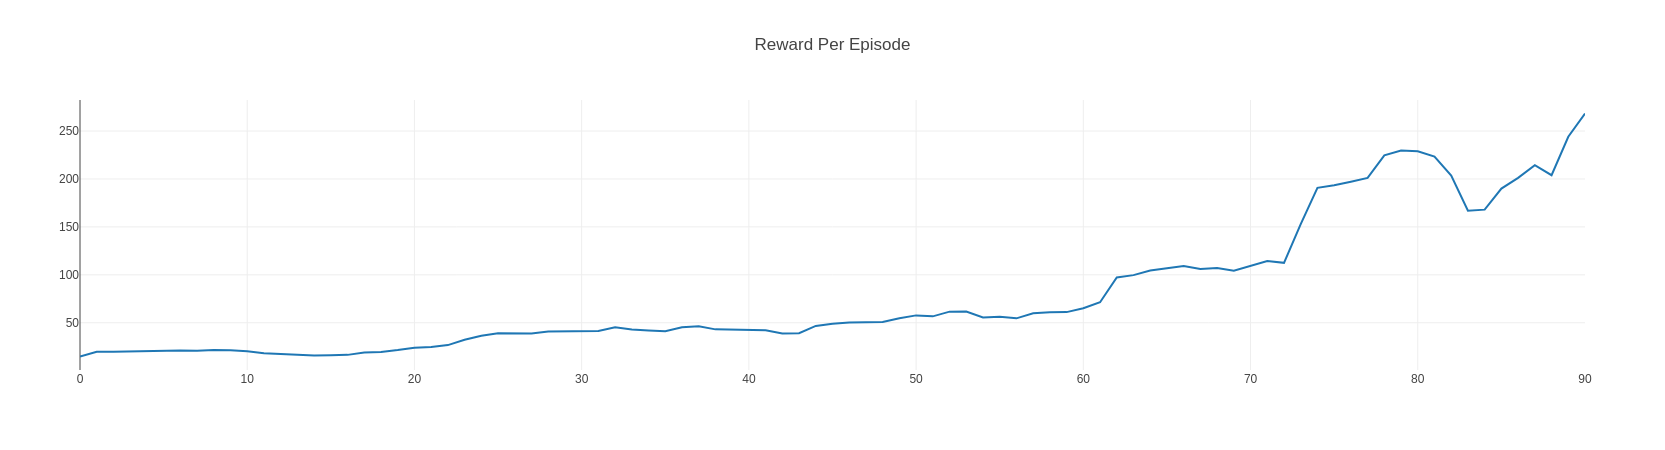

In [24]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 10))],
    "layout": go.Layout(title="Reward Per Episode")
})

# Conclusion

This final section has us produce an Advantage Actor-Critic (A2C) agent, which is considered one of the current state-of-the-art in reinforcement learning methods :D although our implementation isn't perfect (and _very_ ineffecient), it demonstrates just how comprehensible this algorithm is.

Moving forward, we can adjust our learning method so as to implement Proximal Policy Optimization (PPO).  This can be done almost entirely by adjusting our loss function, and the resulting algorithm will be more robust and capable of learning very difficult environments.  PPO is the default reinforcement learning algorithm at OpenAI (with good reason), and is currently being used to solve complex robotic tasks as well as excelling in complex video games such as Dota 2.  More on PPO here:

https://blog.openai.com/openai-baselines-ppo/